In [32]:
import apriltag
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
import glob
from scipy.optimize import minimize, least_squares
from scipy.spatial.transform import Rotation as scipy_R
import random
import os

In [33]:
%matplotlib inline

# APRILTAG CORNER DEBUG IMAGE GENERATION

In [34]:
serial_number = '22240389'



serial_number = '22206080'

apriltag_one_side_length = 48.3

render_debug = True

data_root = '/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/intrinsic_images'
debug_dir = os.path.join(data_root, serial_number + '_intrinsic_debug')

detector = apriltag.Detector()

if not os.path.exists(debug_dir):
    os.makedirs(debug_dir)

images = glob.glob(os.path.join(data_root, serial_number, '*.jpg'))
images.sort()

print(len(images))

blue = [255,0,0]
red = [0,0,255]
greed = [0,255,0]
purple = [255,0,255]
colors = [blue, red, greed, purple]

frame = 0
# detector rescale factor is, for preventing apriltag error. apriltag error is caused by the detector's high resolution.
detector_rescaler = 0.5

for fname in images:
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    result = detector.detect(img)
    img = cv2.resize(img, (0,0), fx=detector_rescaler, fy=detector_rescaler)
    img_plot = cv2.imread(fname)
    img_plot = cv2.resize(img_plot, (0,0), fx=detector_rescaler, fy=detector_rescaler)
    num_detection = len(result)

    for i_tag in range(num_detection):
    
        one_tag = result[i_tag]
        one_tagname = result[i_tag].tag_family
        one_corners = result[i_tag].corners
        one_corners *= detector_rescaler
        # one_corners /= detector_rescaler

        if render_debug:
            for i_corner in range(4):
                img_plot = cv2.circle(img_plot, (int(one_corners[i_corner,0]),int(one_corners[i_corner,1])), 0, colors[i_corner], 10)
    
    if render_debug:
        cv2.imwrite(os.path.join(debug_dir,'%04d.jpg'%frame), img_plot)
        frame += 1
    

0


# APRILTAG IMAGE LOAD

In [35]:
apriltag_image_dir = '/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/ros-apriltag-board.png'

img = cv2.imread(apriltag_image_dir, cv2.IMREAD_GRAYSCALE)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
print(img.shape)
#april_sample.png
detector = apriltag.Detector()
base_result = detector.detect(img)

(2100, 2800)


In [36]:
blue = [255,0,0]
red = [0,0,255]
greed = [0,255,0]
purple = [255,0,255]

colors = [blue, red, greed, purple]
num_detection = len(base_result)

img_plot = cv2.imread(apriltag_image_dir)
img_plot = cv2.rotate(img_plot, cv2.ROTATE_90_COUNTERCLOCKWISE)

for i_tag in range(num_detection):
    
    one_tag = base_result[i_tag]
    one_tagname = base_result[i_tag].tag_family
    one_corners = base_result[i_tag].corners
    
    for i_corner in range(4):
        img_plot = cv2.circle(img_plot, (int(one_corners[i_corner,0]),int(one_corners[i_corner,1])), 0, colors[i_corner], 30)

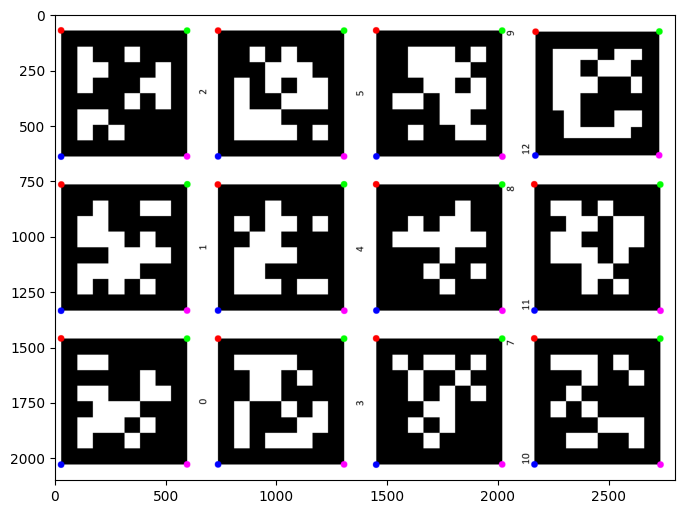

In [37]:
fig=plt.figure(figsize=(8,12), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img_plot[:,:,::-1])

In [38]:
base_result[0].homography

array([[-1.02445123e-12, -7.07104597e-01, -7.76696614e-01],
       [ 7.07104597e-01, -2.91345499e-10, -4.33831661e+00],
       [-5.58889287e-16, -1.67399102e-13, -2.48542916e-03]])

# SYNTHESIS 3D Points and DO INTRINSIC CAL

In [39]:
options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)

images = glob.glob(os.path.join(data_root, serial_number, '*.png'))
images.sort()

print('total number of image is %d'%len(images))

blue = [255,0,0]
red = [0,0,255]
greed = [0,255,0]
purple = [255,0,255]
colors = [blue, red, greed, purple]

frame = 0
# detector rescale factor is, for preventing apriltag error. apriltag error is caused by the detector's high resolution.
# detector_rescaler = 0.5
# detector rescale factor doesn't need.

april_objpoints = []
april_imgpoints = []
april_imagename = []

for fname in images:
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    img_shape = img.shape
    result = detector.detect(img)
    
    img_plot = cv2.imread(fname)
    num_detection = len(result)

    if num_detection != 12:
        print('%s has %d tags'%(fname, num_detection))
        continue

    detected_tag = []
    april_imgpt = []

    for i_tag in range(num_detection):
        one_tag = result[i_tag]
        detected_tag.append(one_tag.tag_id)
        one_corners = one_tag.corners
        april_imgpt.append(one_corners)
        
    april_imgpt = np.array(april_imgpt)
    april_imgpt = april_imgpt.reshape(-1, 1, 2)
    april_imgpoints.append(april_imgpt.astype(np.float32))
    # MAKE OBJP
    apriltag_objp = []
    for i_tag in detected_tag:
        base_one_tag = base_result[i_tag]
        base_one_corners = base_one_tag.corners
        apriltag_objp.append(base_one_corners)

    apriltag_objp = np.array(apriltag_objp)
    apriltag_objp = apriltag_objp.reshape(-1,2)
    _zeros = np.zeros([apriltag_objp.shape[0],1])
    apriltag_objp = np.concatenate([apriltag_objp, _zeros], axis=1)
    apriltag_objp *= apriltag_one_side_length/(597.00000089 - 27.99999955)
    april_objpoints.append(apriltag_objp.astype(np.float32))
    april_imagename.append(fname)

assert len(april_imagename)==len(april_imgpoints)==len(april_objpoints), 'Error: image name, image points, object points are not matched.'

print('number of images that are satisfying condition is %d'%len(april_imagename))

total number of image is 79


/tmp/pip-install-0t0y7l3p/apriltag_2cc2131229084866844982ff09d8db6e/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-0t0y7l3p/apriltag_2cc2131229084866844982ff09d8db6e/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(


number of images that are satisfying condition is 79


In [40]:
# randomly sample a subset of april_imgpoints and april_objpoints and april_imagename. no duplicated.
num_sample = 79
total_num = len(april_imgpoints)
sample_idx = np.random.choice(total_num, num_sample, replace=False)
april_imgpoints_sampled = [april_imgpoints[i] for i in sample_idx]
april_objpoints_sampled = [april_objpoints[i] for i in sample_idx]
april_imagename_sampled = [april_imagename[i] for i in sample_idx]


In [41]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(april_objpoints_sampled, april_imgpoints_sampled, img_shape[::-1],None,None)
print(ret)
print(mtx)
print(dist)

1.6292811645362417
[[1.08795049e+03 0.00000000e+00 1.00875896e+03]
 [0.00000000e+00 1.08534582e+03 8.05856155e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.0020586   0.08521683  0.00111204 -0.00168196 -0.04858111]]


In [42]:
serial_number

'22206080'

In [45]:
_npz_file = np.load(os.path.join('/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image', serial_number + '_intrinsic_result.npz'))
_mtx = _npz_file['mtx']
_dist = _npz_file['dist']
print(_mtx)
print(_dist)


[[1.03199577e+03 0.00000000e+00 1.00252441e+03]
 [0.00000000e+00 1.02474469e+03 8.16941738e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.0450175   0.08368272  0.00310366  0.001471   -0.03886302]]


In [46]:
_K = np.load(os.path.join('/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/bundle_result', serial_number + '_K.npy'))
_distort = np.load(os.path.join('/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/bundle_result', serial_number + '_dist.npy'))
print(_K)
print(_distort)

[[1.03199578e+03 0.00000000e+00 1.00252483e+03]
 [0.00000000e+00 1.02474463e+03 8.16941801e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.03630406  0.09110053  0.01374087  0.01447991 -0.04417381]]


In [11]:
# chack reprojection error of calibration
mean_error = 0
error_holder = []
for i in range(len(april_imgpoints_sampled)):
    imgpoints2, _ = cv2.projectPoints(april_objpoints_sampled[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(april_imgpoints_sampled[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
    error_holder.append(error)

mean_error = mean_error/len(april_imgpoints_sampled)
print(mean_error)


0.07459045531278335


In [12]:
# save calibration result with serial number
np.savez(os.path.join(data_root, serial_number + '_intrinsic_result.npz'), mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

In [13]:
# # load calibration result with serial number
# npzfile = np.load(os.path.join(data_root, serial_number + '_intrinsic_result.npz'))
# mtx = npzfile['mtx']
# dist = npzfile['dist']
# rvecs = npzfile['rvecs']
# tvecs = npzfile['tvecs']


In [9]:
import numpy as np
data_root = '/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/intrinsic_images'

serial_number_list = ['22240382', '22206080', '22222961', '22240368', '22240376', '22240389']
serial_number = serial_number_list[5]


npzfile = np.load(os.path.join(data_root, serial_number + '_intrinsic_result.npz'))
mtx = npzfile['mtx']
dist = npzfile['dist']
rvecs = npzfile['rvecs']
tvecs = npzfile['tvecs']

print('mtx : \n', mtx)
print('dist : \n', dist)

mtx : 
 [[1.05465918e+03 0.00000000e+00 1.01693917e+03]
 [0.00000000e+00 1.05418640e+03 7.57429998e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 
 [[-0.05041824  0.08685294  0.00033135 -0.00095683 -0.04116844]]


In [12]:
mtx[2,2]

1.0

In [15]:
dist.shape

(1, 5)

In [16]:
dist.reshape(1,5,1)

array([[[-0.05041824],
        [ 0.08685294],
        [ 0.00033135],
        [-0.00095683],
        [-0.04116844]]])

In [17]:
np.array([[[0.0],
              [ 0.0]]]).shape

(1, 2, 1)